In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.io import fits

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Generisemo set podataka za jedan linearan model: $y = kx + n$

In [32]:
x = np.linspace(0,10,21)
k = 1.3
n = 2.6

y = 1.3 * x + n 

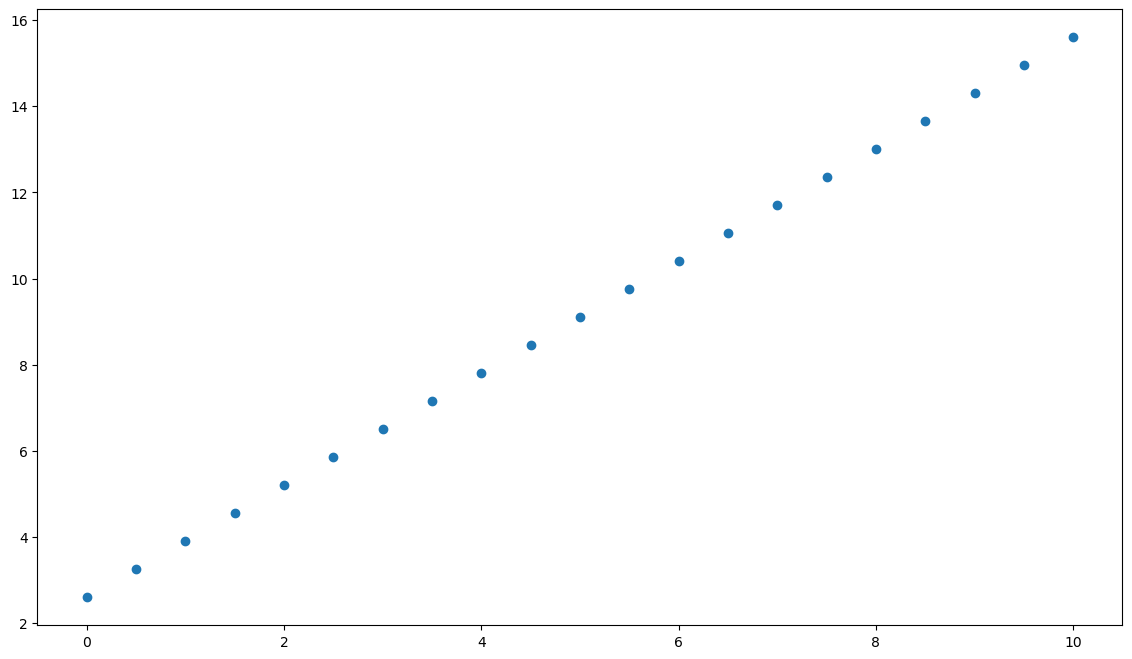

In [33]:
plt.figure(figsize=[14,8])
plt.plot(x,y, 'o')

# Dodajemo neku neodredjenost



In [34]:
sigma = 0.1

y = y+np.random.normal(0,sigma,21)

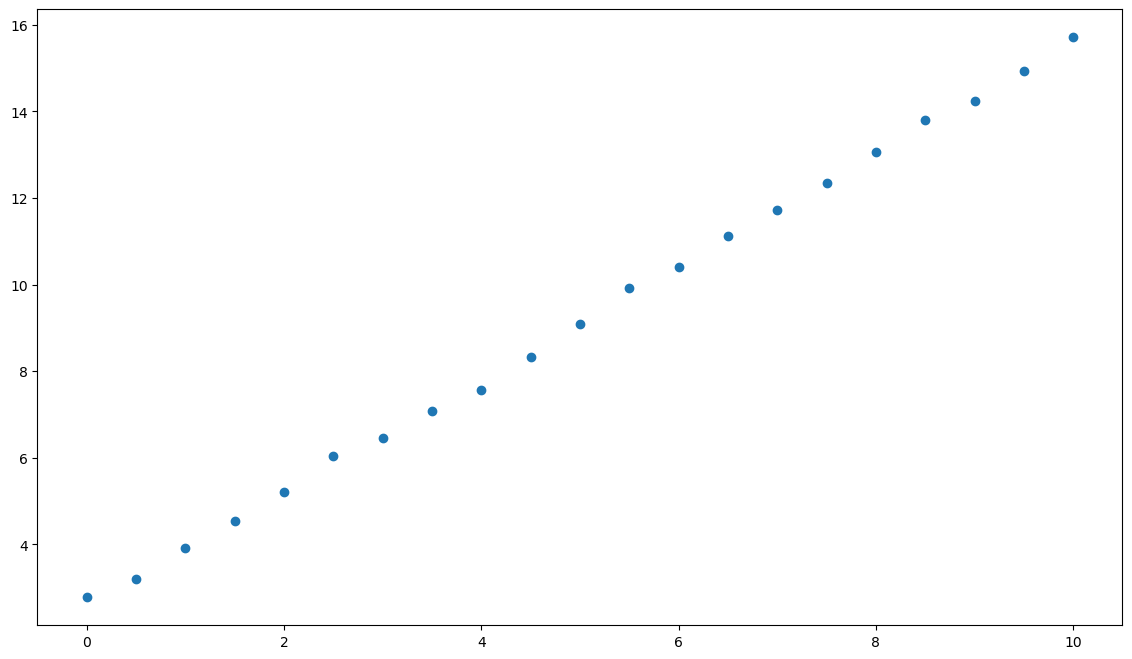

In [35]:
plt.figure(figsize=[14,8])
plt.plot(x,y, 'o')

# setimo se da: 

# ${\mathcal L}(\hat{y}| k,n) = \Pi_i \frac{1}{\sqrt{2\pi}\sigma} e^{-(f(x_i|k,n) - y_i)^2 / 2 \sigma^2}$

In [8]:
# Umesto da pisemo likelyhood, mi pisemo log likelyhood (odnosno u ovom slucaju, ln)

def ln_like(params, x, y, error):
    
    k,n = params
    
    y_model = k * x + n # ovo je kljucni deo
    
    chi2 = np.sum(((y_model - y) / error)**2)
    
    return -0.5 * chi2

In [36]:
import emcee
ndim = 2
nwalkers = 50 # this is number of random points

guess = np.array([1.0,0.0])

starting_params = np.zeros([nwalkers,ndim])

starting_params[:,:] = guess[None,:]

starting_params += np.random.normal(0,1E-1,100).reshape(50,2)



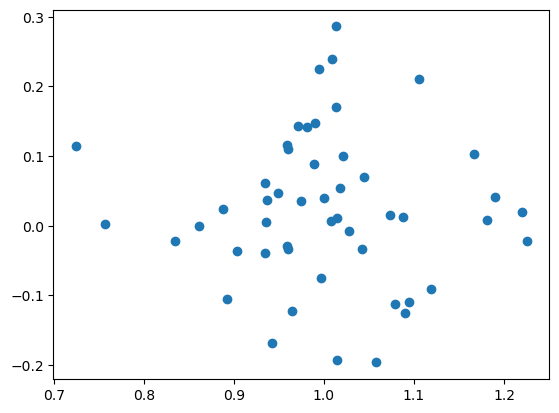

In [37]:
plt.plot(starting_params[:,0],starting_params[:,1],'o')

In [38]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_like, args=[x,y,sigma])

num_steps = 2000
test1,test2,test3 = sampler.run_mcmc(starting_params, num_steps)

In [39]:
# Lokacije svih tackica su bile u sampler.chain

In [40]:
sampler.chain.shape

(50, 2000, 2)

In [41]:
polozaji = np.copy(sampler.chain).reshape(100000,2)

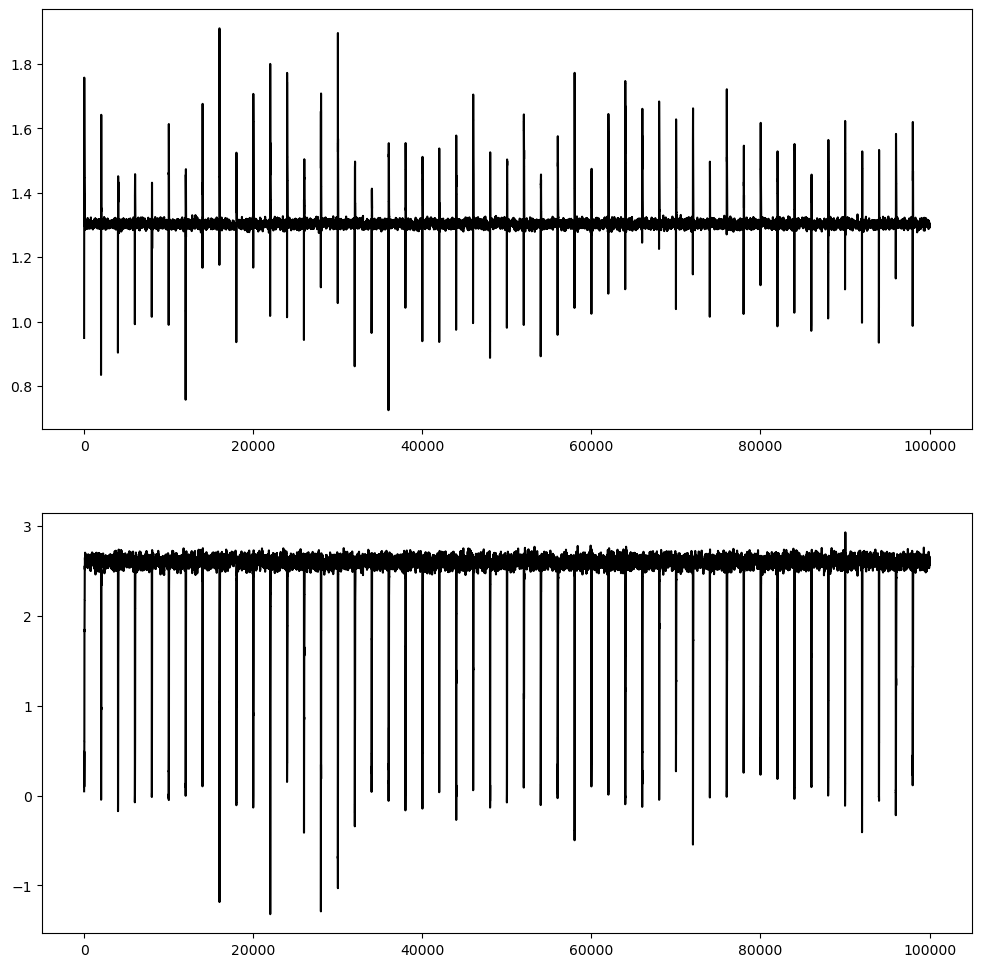

In [42]:
plt.figure(figsize=[12,12])
plt.subplot(211)
plt.plot(polozaji[:,0],'-k')
plt.subplot(212)
plt.plot(polozaji[:,1],'-k')

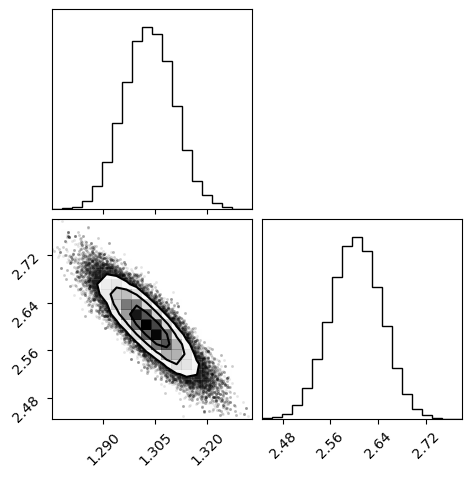

In [43]:
import corner
figure = corner.corner(sampler.flatchain[10000:])

# Za domaci ko hoce 

In [5]:
# Let's first look at the data
stokes = fits.open("/home/milic/data/Hinode_network/hinode_network_c.fits")[0].data

In [6]:
stokes.shape
stokes /= np.mean(stokes[:,:,0,:10])

In [7]:
# Let's also assign wavelengths:
ll = np.linspace(0,111,112)
ll = 6302.08 + (ll-56.5)*0.0215

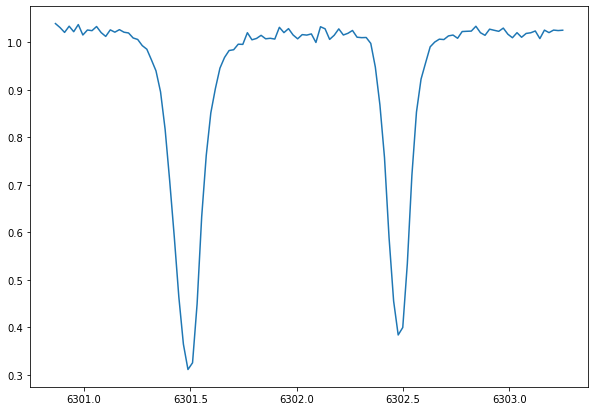

In [8]:
# Plot one spectrum:
plt.figure(figsize=[10,7])
plt.plot(ll,stokes[100,100,0,:])

In [9]:
# Now we need to fit this. Let's first code the model. 
from scipy.special import wofz
def V(x, alpha, gamma):
    """
    Return the Voigt line shape at x with Lorentzian component HWHM gamma
    and Gaussian component HWHM alpha.

    """
    sigma = alpha / np.sqrt(2 * np.log(2))

    return np.real(wofz((x + 1j*gamma)/sigma/np.sqrt(2))) / sigma /np.sqrt(2*np.pi)

def voigt(center,doppler,damp,ll):
    xx = (ll - center)/doppler
    return V(xx,1.0,damp)
    

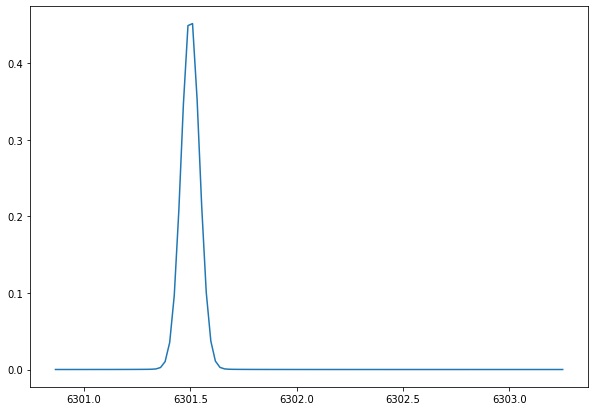

In [10]:
# check if it works!
plt.figure(figsize=[10,7])
plt.plot(ll,voigt(6301.5,0.05,1E-2,ll))

In [11]:
# Now let's define ou model and relevant probabilities
def me_scalar(p,ll):
    # for clarity
    a0,a1,eta,shift,width,damping = p
    # let's assume the width is in km/s units
    width *= np.mean(ll)/2.997E5
    # le's assume the shift is also in km/s 
    center = 6301.49 * (1.+shift/2.997E5)
    profile = voigt(center,width,damping,ll)
    r_lambda = 1. + profile * eta
    return a0 + a1/r_lambda

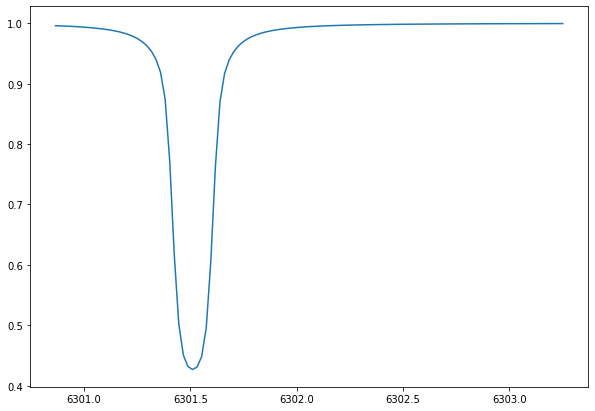

In [12]:
# Let's see if it works
plt.figure(figsize=[10,7])
plt.plot(ll,me_scalar([0.4,0.6,50.,1.0,2.0,1E-1],ll))

In [13]:
# Now the relevant probabilities
def ln_prior(params):
    # Both slope and offset positive
    a0,a1,eta,shift,width,damping = params
    if (a0 < 0):
        return -np.infty
    if (a1 < 0):
        return -np.infty
    if (eta < 0 or eta > 200.):
        return - np.infty
    if (shift < -20. or shift > 20.):
        return - np.infty
    if (shift < -10. or shift > 10.):
        return - 22.
    if (width < 0.1 or width > 10.0):
        return - np.infty
    if (damping < 1E-4 or damping > 1.0):
        return - np.infty
    return 0.

def ln_like(params, x, y, error):
    
    y_model = me_scalar(params,x)
    
    chi2 = np.sum(((y_model - y) / error)**2)
    
    return -0.5 * chi2 # - 0.5*np.log(2*np.pi) - np.log(error)) # I am making it depend on errors in purpose

def ln_post(params, x, y, error):
    
    lnprior_val = ln_prior(params)
    
    if ~np.isfinite(lnprior_val):
        return lnprior_val
    else:           
        lnlike_val = ln_like(params, x, y, error)
        return lnprior_val + lnlike_val

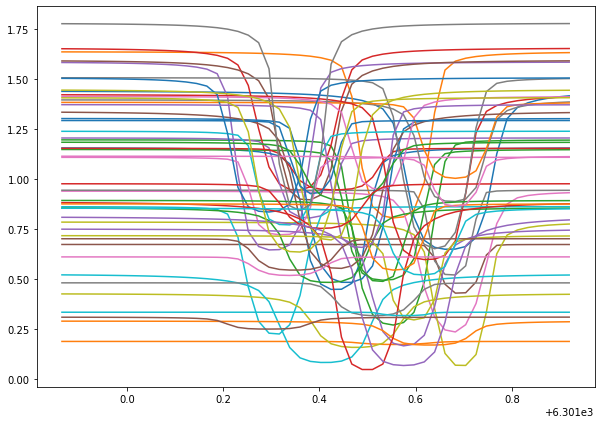

In [14]:
import emcee
ndim = 6
nwalkers = 50 # this is number of random points
i = 150
j = 150

x_data = ll[:50]
y_data = stokes[i,j,0,:50]
errors = np.zeros(50)
errors[:] = y_data[0]*1E-2


starting_params = np.zeros([nwalkers,ndim])
starting_params[:,0] = np.random.uniform(0.,1.,nwalkers)
starting_params[:,1] = np.random.uniform(0.,1.,nwalkers)
starting_params[:,2] = np.random.uniform(10.,100.,nwalkers)
starting_params[:,3] = np.random.uniform(-10.,10.,nwalkers)
starting_params[:,4] = np.random.uniform(1.0,2.0,nwalkers)
starting_params[:,5] = np.random.uniform(1E-2,1E-1,nwalkers)

plt.figure(figsize=[10,7])
for i in range (0,nwalkers):
    plt.plot(x_data,me_scalar(starting_params[i,:],x_data))

In [15]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post, args=[x_data,y_data,errors])

num_steps = 2000
test1,test2,test3 = sampler.run_mcmc(starting_params, num_steps)

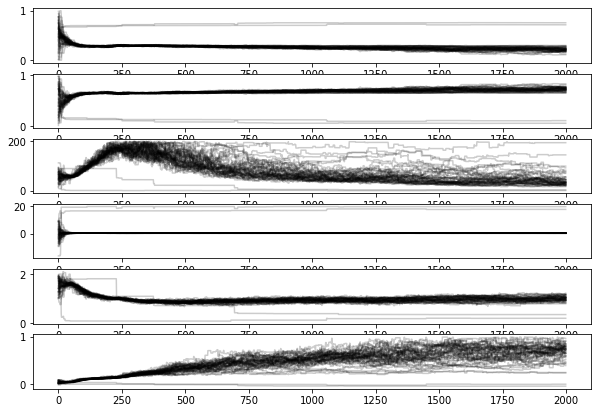

In [16]:
plt.figure(figsize=[10,7])
plt.subplot(611)
plt.plot(sampler.chain[:, :, 0].T, '-k', alpha=0.2)
plt.subplot(612)
plt.plot(sampler.chain[:, :, 1].T, '-k', alpha=0.2)
plt.subplot(613)
plt.plot(sampler.chain[:, :, 2].T, '-k', alpha=0.2)
plt.subplot(614)
plt.plot(sampler.chain[:, :, 3].T, '-k', alpha=0.2)
plt.subplot(615)
plt.plot(sampler.chain[:, :, 4].T, '-k', alpha=0.2)
plt.subplot(616)
plt.plot(sampler.chain[:, :, 5].T, '-k', alpha=0.2)

In [17]:
best = np.median(sampler.flatchain,axis=0)
print (best)

[ 0.2704425   0.67289744 65.83394845  0.375519    0.94062812  0.4633111 ]


-23.481615784540296


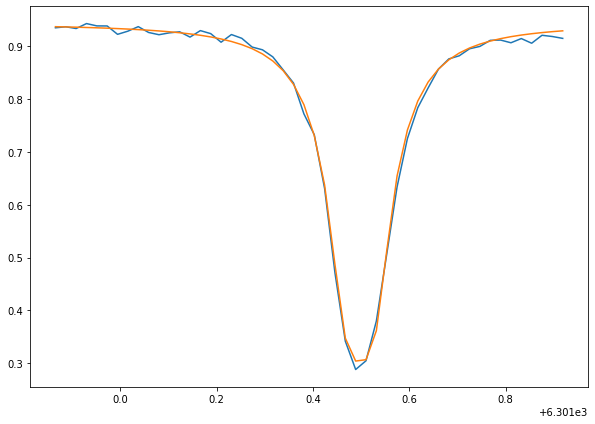

In [18]:
plt.figure(figsize=[10,7])
plt.plot(x_data,y_data)
plt.plot(x_data,me_scalar(best,x_data))
print (ln_like(best,x_data,y_data,errors))

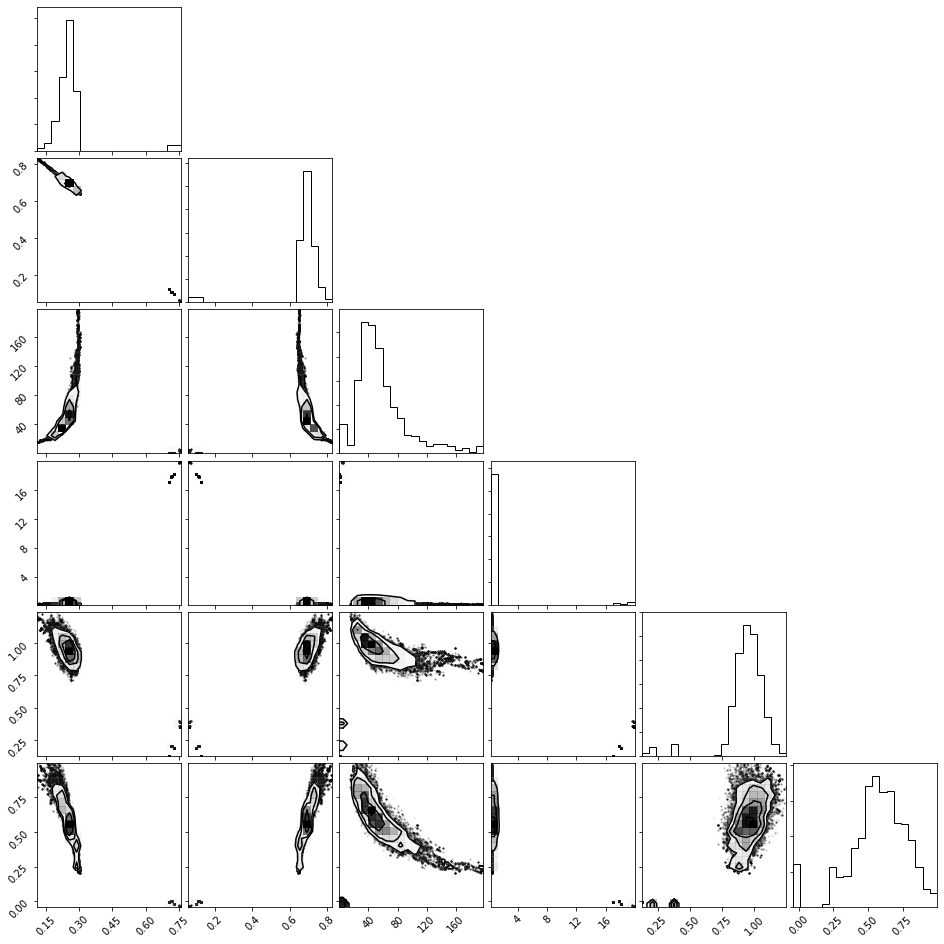

In [19]:
#import corner
#figure = corner.corner(sampler.flatchain[40000:])

In [25]:
#let's try now scipy.optimize.minimize

def chi2(params, x,y,error):
    
    y_model = me_scalar(params,x)
    
    chi2 = np.sum(((y_model - y) / error)**2)
    
    return chi2

In [26]:
from scipy.optimize import minimize

In [30]:
result = minimize(chi2,starting_params[3],args=(x_data,y_data,errors),method='Nelder-Mead')

In [31]:
result.x

array([ 0.16332315,  0.77831564, 21.21751272,  0.37053831,  1.12616668,
        0.85159414])

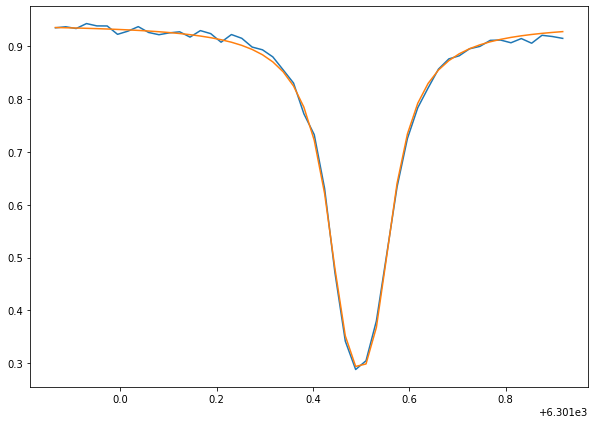

In [32]:
plt.figure(figsize=[10,7])
plt.plot(x_data,y_data)
plt.plot(x_data,me_scalar(result.x,x_data))
